In [48]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import new_alg_v2 as na


In [49]:
import numpy as np
import torch
# MNIST dataset
from torchvision.datasets import MNIST
from torchvision import transforms
    
def define_dataloaders(n_examples_train, n_examples_test, classes=np.arange(10), zscore_images=True):
    # MNIST data, batch training
    batch_size = n_examples_train
    batches_per_epoch_train = n_examples_train / batch_size
    batches_per_epoch_test = n_examples_test / batch_size

    # Choose the classes (at most 10)
    assert max(classes) <= 9

    # Transformation for the images
    transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])
    #transform = transforms.Compose([transforms.ToTensor(),
    #                              transforms.Normalize((0.5,), (0.5,)),
    #                              ])
    trainset = MNIST(data_dir, download=True, train=True, transform=transform)
    testset = MNIST(data_dir, download=True, train=False, transform=transform)

    # Obtain training and test data. 
    # Note that both datasets are sorted, but the train and test loaders will shuffle them during training.
    n_examples_tt = [n_examples_train, n_examples_test]
    for i_d, (n_examples_i, dataset) in enumerate(zip(n_examples_tt, [trainset, testset])):
        n_per_class = n_examples_i // len(classes)
        data_orig = dataset.data.detach().clone()
        targets_orig = dataset.targets.detach().clone()
        for i_c, class_i in enumerate(classes):
            mask = targets_orig == class_i
            i0 = i_c * n_per_class
            i1 = (i_c+1) * n_per_class
            dataset.data[i0:i1] = data_orig[mask][:n_per_class]
            dataset.targets[i0:i1] = targets_orig[mask][:n_per_class]
        # Fill the remaining slots with random classes from the available choices
        n_remain = n_examples_i - i1 
        for i in range(n_remain):
            class_i = np.random.choice(classes)
            mask = targets_orig == class_i
            idx_i = np.random.choice(torch.where(mask)[0][i1:].cpu())
            dataset.data[i1+i] = data_orig[idx_i]
            dataset.targets[i1+i] = targets_orig[idx_i]

        # Cut off
        dataset.data = dataset.data[:n_examples_i]
        dataset.targets = dataset.targets[:n_examples_i]

    # Batch-loader
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

    return trainloader, testloader

In [50]:
n_epochs = 2000
learning_rate = 0.01
momentum = 0
torch.backends.cudnn.enabled = False


In [51]:
## no dopout
#Building the Network

conv1_out= 10
conv2_out=20
fc1_in=320
fc2_in=50

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, conv1_out, kernel_size=5)
        self.conv2 = nn.Conv2d(conv1_out, conv2_out, kernel_size=5)
        #self.conv2_drop = nn.Dropout2d() --- no dropout
        self.fc1 = nn.Linear(fc1_in, fc2_in)
        self.fc2 = nn.Linear(fc2_in, 10)

    def forward(self, x):
        x = torch.tanh(F.max_pool2d(self.conv1(x), 2))
        #x = torch.tanh(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = torch.tanh(F.max_pool2d((self.conv2(x)), 2))
        x = x.view(-1, fc1_in)
        x = torch.tanh(self.fc1(x))
      #  x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [52]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
loss_f=nn.CrossEntropyLoss()

In [53]:
# save the initial weights to measure later their contribution:
fc1_init = network.fc1.weight.clone()
fc2_init = network.fc2.weight.clone()
conv1_init = network.conv1.weight.clone()
conv2_init = network.conv2.weight.clone()

In [54]:
data_dir = '/files/'
n_examples_train = 1000
n_examples_test = 500
train_loader, test_loader = define_dataloaders(n_examples_train, n_examples_test)

train_losses = []
test_losses = []

In [55]:
def train(epoch):
  train_n = 5
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = loss_f(output,target)
    loss.backward()
    optimizer.step()
    if epoch % train_n == 0:
      print('Train Epoch: {} \tLoss: {:.6f}'.format(
          epoch,
          loss.item()))
    train_losses.append(loss.item())

In [56]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += loss_f(output,target)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= 1 #1 is the amount of test batches
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss,
    correct,
    len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


In [57]:
test_n = 25
test()
count = []
for epoch in range(1, n_epochs + 1):
  train(epoch)
  if epoch % test_n == 0:
    test()
    count.append(epoch)


Test set: Avg. loss: 2.3017, Accuracy: 55/500 (11%)

Train Epoch: 5 	Loss: 2.299567
Train Epoch: 10 	Loss: 2.291218
Train Epoch: 15 	Loss: 2.282929
Train Epoch: 20 	Loss: 2.274658
Train Epoch: 25 	Loss: 2.266371

Test set: Avg. loss: 2.2650, Accuracy: 83/500 (17%)

Train Epoch: 30 	Loss: 2.258003
Train Epoch: 35 	Loss: 2.249528
Train Epoch: 40 	Loss: 2.240916
Train Epoch: 45 	Loss: 2.232136
Train Epoch: 50 	Loss: 2.223114

Test set: Avg. loss: 2.2261, Accuracy: 146/500 (29%)

Train Epoch: 55 	Loss: 2.213825
Train Epoch: 60 	Loss: 2.204246
Train Epoch: 65 	Loss: 2.194346
Train Epoch: 70 	Loss: 2.184070
Train Epoch: 75 	Loss: 2.173366

Test set: Avg. loss: 2.1802, Accuracy: 217/500 (43%)

Train Epoch: 80 	Loss: 2.162195
Train Epoch: 85 	Loss: 2.150515
Train Epoch: 90 	Loss: 2.138319
Train Epoch: 95 	Loss: 2.125541
Train Epoch: 100 	Loss: 2.112130

Test set: Avg. loss: 2.1229, Accuracy: 258/500 (52%)

Train Epoch: 105 	Loss: 2.098078
Train Epoch: 110 	Loss: 2.083364
Train Epoch: 115 	Los

Text(0, 0.5, 'loss')

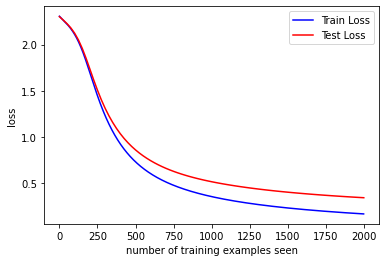

In [58]:
x = np.arange(0,n_epochs)
count = np.arange(0,n_epochs+test_n,test_n)

fig = plt.figure()
plt.plot(x, train_losses, color='blue', zorder=1)
plt.plot(count, test_losses, color='red', zorder=2)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('loss')

In [59]:
# save the final weights to measure later their contribution:
conv_1_final= network.conv1.weight.clone()
conv_2_final =network.conv2.weight.clone()
fc_1_final= network.fc1.weight.clone()
fc_2_final= network.fc2.weight.clone()
first_losses=test_losses.copy()
test_losses.clear()

In [60]:

# calculate the contribution of every layer

with torch.no_grad():
    network.fc1.weight[:] = fc1_init
test()

with torch.no_grad():
    network.fc1.weight[:] = fc_1_final
    network.fc2.weight[:] = fc2_init
test()

with torch.no_grad():
    network.fc2.weight[:] = fc_2_final
    network.conv1.weight[:] = conv1_init
test()

with torch.no_grad():
    network.conv1.weight[:] = conv_1_final
    network.conv2.weight[:] = conv2_init
test()

with torch.no_grad():
    network.conv2.weight[:] = conv_2_final







Test set: Avg. loss: 1.5483, Accuracy: 303/500 (61%)


Test set: Avg. loss: 1.0275, Accuracy: 428/500 (86%)


Test set: Avg. loss: 0.4434, Accuracy: 430/500 (86%)


Test set: Avg. loss: 1.2716, Accuracy: 279/500 (56%)



In [61]:
print("fc1 contribution is: ",test_losses[0])

print("fc2 contribution is: ",test_losses[1])

print("conv1 contribution is: ",test_losses[2])

print("conv2 contribution is: ",test_losses[3])

fc1 contribution is:  tensor(1.5483)
fc2 contribution is:  tensor(1.0275)
conv1 contribution is:  tensor(0.4434)
conv2 contribution is:  tensor(1.2716)


In [91]:
#train only fc1:
network = Net()
train_losses.clear()
test_losses.clear()
#count=[]
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

#freeze the other layers:
network.fc2.weight.requires_grad=False
network.fc2.bias.requires_grad=False

network.conv2.weight.requires_grad=False
network.conv2.bias.requires_grad=False

network.conv1.weight.requires_grad=False
network.conv1.bias.requires_grad=False
optimizer = optim.SGD(filter(lambda p: p.requires_grad, network.parameters()), lr=learning_rate, momentum=momentum)


# save the initial weights to measure later their contribution:
fc1_init = network.fc1.weight.clone()
fc2_init = network.fc2.weight.clone()
conv1_init = network.conv1.weight.clone()
conv2_init = network.conv2.weight.clone()

#train
test_n = 25
test()
count = []
n_epochs=5000
for epoch in range(1, n_epochs + 1):
  train(epoch)
  if epoch % test_n == 0:
    test()
    count.append(epoch)


Test set: Avg. loss: 2.3176, Accuracy: 41/500 (8%)

Train Epoch: 5 	Loss: 2.311023
Train Epoch: 10 	Loss: 2.305203
Train Epoch: 15 	Loss: 2.299477
Train Epoch: 20 	Loss: 2.293839
Train Epoch: 25 	Loss: 2.288283

Test set: Avg. loss: 2.2909, Accuracy: 54/500 (11%)

Train Epoch: 30 	Loss: 2.282804
Train Epoch: 35 	Loss: 2.277396
Train Epoch: 40 	Loss: 2.272056
Train Epoch: 45 	Loss: 2.266779
Train Epoch: 50 	Loss: 2.261562

Test set: Avg. loss: 2.2661, Accuracy: 70/500 (14%)

Train Epoch: 55 	Loss: 2.256400
Train Epoch: 60 	Loss: 2.251292
Train Epoch: 65 	Loss: 2.246234
Train Epoch: 70 	Loss: 2.241223
Train Epoch: 75 	Loss: 2.236258

Test set: Avg. loss: 2.2427, Accuracy: 98/500 (20%)

Train Epoch: 80 	Loss: 2.231335
Train Epoch: 85 	Loss: 2.226454
Train Epoch: 90 	Loss: 2.221612
Train Epoch: 95 	Loss: 2.216808
Train Epoch: 100 	Loss: 2.212039

Test set: Avg. loss: 2.2204, Accuracy: 141/500 (28%)

Train Epoch: 105 	Loss: 2.207306
Train Epoch: 110 	Loss: 2.202606
Train Epoch: 115 	Loss: 

Text(0, 0.5, 'loss')

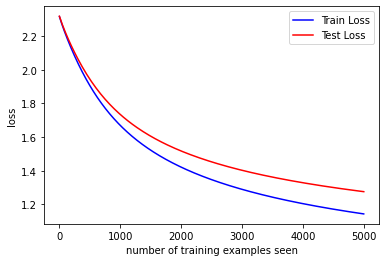

In [92]:
x = np.arange(0,n_epochs)
count = np.arange(0,n_epochs+test_n,test_n)

fig = plt.figure()
plt.plot(x, train_losses, color='blue', zorder=1)
plt.plot(count, test_losses, color='red', zorder=2)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('loss')

In [94]:
#train only conv1:
network = Net()
train_losses.clear()
test_losses.clear()
#count=[]
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

#freeze the other layers:
network.fc2.weight.requires_grad=False
network.fc2.bias.requires_grad=False

network.fc1.weight.requires_grad=False
network.fc1.bias.requires_grad=False

network.conv2.weight.requires_grad=False
network.conv2.bias.requires_grad=False
optimizer = optim.SGD(filter(lambda p: p.requires_grad, network.parameters()), lr=learning_rate, momentum=momentum)


# save the initial weights to measure later their contribution:
fc1_init = network.fc1.weight.clone()
fc2_init = network.fc2.weight.clone()
conv1_init = network.conv1.weight.clone()
conv2_init = network.conv2.weight.clone()

#train
test_n = 25
test()
count = []
n_epochs=5000
for epoch in range(1, n_epochs + 1):
  train(epoch)
  if epoch % test_n == 0:
    test()
    count.append(epoch)


Test set: Avg. loss: 2.3084, Accuracy: 48/500 (10%)

Train Epoch: 5 	Loss: 2.306231
Train Epoch: 10 	Loss: 2.305928
Train Epoch: 15 	Loss: 2.305624
Train Epoch: 20 	Loss: 2.305322
Train Epoch: 25 	Loss: 2.305022

Test set: Avg. loss: 2.3071, Accuracy: 49/500 (10%)

Train Epoch: 30 	Loss: 2.304723
Train Epoch: 35 	Loss: 2.304424
Train Epoch: 40 	Loss: 2.304123
Train Epoch: 45 	Loss: 2.303822
Train Epoch: 50 	Loss: 2.303525

Test set: Avg. loss: 2.3059, Accuracy: 49/500 (10%)

Train Epoch: 55 	Loss: 2.303227
Train Epoch: 60 	Loss: 2.302928
Train Epoch: 65 	Loss: 2.302629
Train Epoch: 70 	Loss: 2.302330
Train Epoch: 75 	Loss: 2.302034

Test set: Avg. loss: 2.3046, Accuracy: 50/500 (10%)

Train Epoch: 80 	Loss: 2.301735
Train Epoch: 85 	Loss: 2.301432
Train Epoch: 90 	Loss: 2.301130
Train Epoch: 95 	Loss: 2.300833
Train Epoch: 100 	Loss: 2.300538

Test set: Avg. loss: 2.3034, Accuracy: 50/500 (10%)

Train Epoch: 105 	Loss: 2.300245
Train Epoch: 110 	Loss: 2.299956
Train Epoch: 115 	Loss: 

Text(0, 0.5, 'loss')

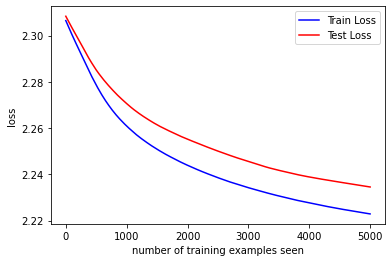

In [95]:
x = np.arange(0,n_epochs)
count = np.arange(0,n_epochs+test_n,test_n)

fig = plt.figure()
plt.plot(x, train_losses, color='blue', zorder=1)
plt.plot(count, test_losses, color='red', zorder=2)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('loss')

In [96]:
#train only fc2:
network = Net()
train_losses.clear()
test_losses.clear()
#count=[]
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

#freeze the other layers:
network.fc1.weight.requires_grad=False
network.fc1.bias.requires_grad=False

network.conv2.weight.requires_grad=False
network.conv2.bias.requires_grad=False

network.conv1.weight.requires_grad=False
network.conv1.bias.requires_grad=False
optimizer = optim.SGD(filter(lambda p: p.requires_grad, network.parameters()), lr=learning_rate, momentum=momentum)


# save the initial weights to measure later their contribution:
fc1_init = network.fc1.weight.clone()
fc2_init = network.fc2.weight.clone()
conv1_init = network.conv1.weight.clone()
conv2_init = network.conv2.weight.clone()

#train
test_n = 25
test()
count = []
n_epochs=5000
for epoch in range(1, n_epochs + 1):
  train(epoch)
  if epoch % test_n == 0:
    test()
    count.append(epoch)


Test set: Avg. loss: 2.2920, Accuracy: 83/500 (17%)

Train Epoch: 5 	Loss: 2.292623
Train Epoch: 10 	Loss: 2.291928
Train Epoch: 15 	Loss: 2.291235
Train Epoch: 20 	Loss: 2.290544
Train Epoch: 25 	Loss: 2.289854

Test set: Avg. loss: 2.2890, Accuracy: 87/500 (17%)

Train Epoch: 30 	Loss: 2.289167
Train Epoch: 35 	Loss: 2.288481
Train Epoch: 40 	Loss: 2.287798
Train Epoch: 45 	Loss: 2.287116
Train Epoch: 50 	Loss: 2.286435

Test set: Avg. loss: 2.2860, Accuracy: 89/500 (18%)

Train Epoch: 55 	Loss: 2.285757
Train Epoch: 60 	Loss: 2.285080
Train Epoch: 65 	Loss: 2.284405
Train Epoch: 70 	Loss: 2.283731
Train Epoch: 75 	Loss: 2.283059

Test set: Avg. loss: 2.2831, Accuracy: 90/500 (18%)

Train Epoch: 80 	Loss: 2.282389
Train Epoch: 85 	Loss: 2.281720
Train Epoch: 90 	Loss: 2.281053
Train Epoch: 95 	Loss: 2.280387
Train Epoch: 100 	Loss: 2.279722

Test set: Avg. loss: 2.2803, Accuracy: 90/500 (18%)

Train Epoch: 105 	Loss: 2.279059
Train Epoch: 110 	Loss: 2.278397
Train Epoch: 115 	Loss: 

Text(0, 0.5, 'loss')

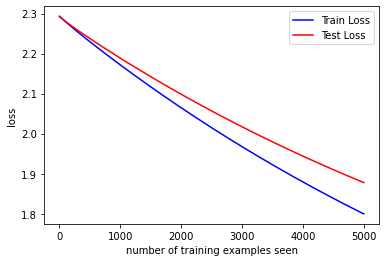

In [97]:
x = np.arange(0,n_epochs)
count = np.arange(0,n_epochs+test_n,test_n)

fig = plt.figure()
plt.plot(x, train_losses, color='blue', zorder=1)
plt.plot(count, test_losses, color='red', zorder=2)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('loss')

In [98]:
#train only conv2:
network = Net()
train_losses.clear()
test_losses.clear()
#count=[]
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

#freeze the other layers:
network.fc2.weight.requires_grad=False
network.fc2.bias.requires_grad=False

network.fc1.weight.requires_grad=False
network.fc1.bias.requires_grad=False

network.conv1.weight.requires_grad=False
network.conv1.bias.requires_grad=False
optimizer = optim.SGD(filter(lambda p: p.requires_grad, network.parameters()), lr=learning_rate, momentum=momentum)


# save the initial weights to measure later their contribution:
fc1_init = network.fc1.weight.clone()
fc2_init = network.fc2.weight.clone()
conv1_init = network.conv1.weight.clone()
conv2_init = network.conv2.weight.clone()

#train
test_n = 25
test()
count = []
n_epochs=5000
for epoch in range(1, n_epochs + 1):
  train(epoch)
  if epoch % test_n == 0:
    test()
    count.append(epoch)


Test set: Avg. loss: 2.2955, Accuracy: 79/500 (16%)

Train Epoch: 5 	Loss: 2.287640
Train Epoch: 10 	Loss: 2.284153
Train Epoch: 15 	Loss: 2.280697
Train Epoch: 20 	Loss: 2.277290
Train Epoch: 25 	Loss: 2.273932

Test set: Avg. loss: 2.2816, Accuracy: 98/500 (20%)

Train Epoch: 30 	Loss: 2.270606
Train Epoch: 35 	Loss: 2.267331
Train Epoch: 40 	Loss: 2.264103
Train Epoch: 45 	Loss: 2.260919
Train Epoch: 50 	Loss: 2.257784

Test set: Avg. loss: 2.2684, Accuracy: 111/500 (22%)

Train Epoch: 55 	Loss: 2.254695
Train Epoch: 60 	Loss: 2.251647
Train Epoch: 65 	Loss: 2.248640
Train Epoch: 70 	Loss: 2.245671
Train Epoch: 75 	Loss: 2.242734

Test set: Avg. loss: 2.2559, Accuracy: 137/500 (27%)

Train Epoch: 80 	Loss: 2.239828
Train Epoch: 85 	Loss: 2.236959
Train Epoch: 90 	Loss: 2.234127
Train Epoch: 95 	Loss: 2.231333
Train Epoch: 100 	Loss: 2.228579

Test set: Avg. loss: 2.2441, Accuracy: 157/500 (31%)

Train Epoch: 105 	Loss: 2.225866
Train Epoch: 110 	Loss: 2.223182
Train Epoch: 115 	Los

Text(0, 0.5, 'loss')

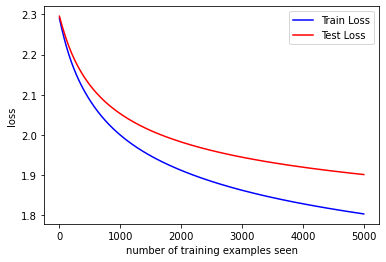

In [99]:
x = np.arange(0,n_epochs)
count = np.arange(0,n_epochs+test_n,test_n)

fig = plt.figure()
plt.plot(x, train_losses, color='blue', zorder=1)
plt.plot(count, test_losses, color='red', zorder=2)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('loss')